# Описание проекта
Нас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет. Выручка измеряется в условных единицах — у.е.

# Доступные данные:
В нашем распоряжении имеются данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

# Цели проекта:
- Изучить, как клиенты пользуются сервисом,
- Изучить, когда клиенты делают первые покупки на сайте,
- Изучить, сколько денег приносит компании каждый клиент,
- Изучить, когда расходы на привлечение клиента окупаются.

# Содержание <a class="anchor" id="zero-bullet"></a>

* [1. Изучение и подготовка данных из файлов](#first-bullet)
    * [1.1. Общие выводы по разделу](#first-zero-bullet)
* [2. Создание метрик и построение графиков ](#second-bullet)
    * [2.1. Продуктовые метрики ](#second-one-bullet)
    * [2.2. Метрики электронной коммерции ](#second-two-bullet)
    * [2.3. Маркетинговые метрики ](#second-three-bullet)
    * [2.4. Общие выводы по разделу ](#second-four-bullet)

* [3. Выводы и рекомендации ](#third-bullet)

# 1. Изучение и подготовка данных из файлов <a class="anchor" id="first-bullet"></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy import stats as st
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Открываем файлы:

In [2]:
try:
    visits_log = pd.read_csv('visits_log.csv')
    orders_log = pd.read_csv('orders_log.csv')
    costs = pd.read_csv('costs.csv')

except:
    visits_log = pd.read_csv('/datasets/visits_log.csv')
    orders_log = pd.read_csv('/datasets/orders_log.csv')
    costs = pd.read_csv('/datasets/costs.csv')

Предпросмотр файла `visits_log`:

In [3]:
visits_log.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
print(visits_log['Device'].unique())

['touch' 'desktop']


Проверим на наличие дубликатов:

In [6]:
duplicates = visits_log[visits_log.duplicated(keep='last')]
print(duplicates)

Empty DataFrame
Columns: [Device, End Ts, Source Id, Start Ts, Uid]
Index: []


Дубликаты отсутствуют.

**Промежуточные выводы:**
- данные однородны, пропусков и неявных дубликатов категорий нет;
- необходимо `привести названия столбцов к нижнему регистру` и убрать пробелы для лучшей читаемости;
- необходимо `привести формат столбцов 'End Ts','Start Ts' к формату datetime`;
- отсутствует расшифровка 'Source Id' - для расчетов это не помешает, но для представления отчетности руководству было бы полезно иметь.

Предпросмотр файла `orders_log`:

In [7]:
orders_log.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
orders_log.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Проверим на наличие дубликатов:

In [10]:
duplicates = orders_log[orders_log.duplicated(keep='last')]
print(duplicates)

Empty DataFrame
Columns: [Buy Ts, Revenue, Uid]
Index: []


Дубликаты отсутствуют.

**Промежуточные выводы:**
- данные однородны, пропусков и дубликатов нет;
- необходимо `привести названия столбцов к нижнему регистру` и убрать пробелы для лучшей читаемости;
- необходимо `привести формат столбца 'Buy Ts' к формату datetime`;
- имеются нулевые значения выручки с пользователя, а также максимальное значение 2633 у.е. Пока не представляется возможным сделать вывод об аномальности этих данных.

Предпросмотр файла `costs`:

In [11]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [13]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


Проверим на наличие дубликатов:

In [14]:
duplicates = costs[costs.duplicated(keep='last')]
print(duplicates)

Empty DataFrame
Columns: [source_id, dt, costs]
Index: []


Дубликаты отсутствуют.

**Промежуточные выводы:**
- данные однородны, пропусков и дубликатов нет;
- необходимо `привести формат столбца 'dt' к формату datetime`;
- имеется значение расходов в размере 1788 у.е. Пока не представляется возможным сделать вывод об аномальности этой суммы.

Сравним значения source id в таблицах visits_log и costs. Для этого воспользуемся функцией Counter() из модуля collections:

In [15]:
c1 = Counter(visits_log['Source Id'].unique())
c2 = Counter(costs['source_id'].unique())

diff = c1-c2
print(list(diff))

[7, 6]


Итак, видим, что в таблице costs отсутствуют категории "6" и "7". Пока неясно, какой эффект будет от отсутствия этих данных. Проверим их количество:

In [16]:
#Количество строк с source id:
print(len(visits_log['Source Id'][visits_log['Source Id'] == 6]))
print(len(visits_log['Source Id'][visits_log['Source Id'] == 7]))

6
36


Как видим, количества данных строк невелики. Скорее всего, за ними скрывается какой-то "экзотический" источник перехода. К сожалению, какой именно, узнать мы не можем по указанной выше причине отсутствия расшифровки источников, а равно и не сможем заменить их на другую подходящую категорию. Поскольку их количество минимально, если они будут нам мешать в дальнейшем, можно будет обойтись без этих строк.

Переименуем столбцы:

In [17]:
visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits_log = visits_log[['uid','device', 'end_ts', 'source_id', 'start_ts']]

orders_log.columns = ['buy_ts', 'revenue', 'uid']

In [18]:
orders_log.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [19]:
visits_log.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


**1.1. Общие выводы по разделу:**<a class="anchor" id="first-zero-bullet"></a>
    
- в целом набор данных подготовлен корректно, пропущенных значений нет (за исключением двух небольших отсутствующих категорий в таблице costs);
- необходимо переименовать столбцы;
- необходимо перевести даты в соответствующий формат (будет выполнено на этапе расчета метрик);
- отсутствует классификатор источников перехода.

[К НАЧАЛУ РАЗДЕЛА...](#first-bullet)

[К СОДЕРЖАНИЮ...](#zero-bullet)

# 2. Создание метрик и построение графиков<a class="anchor" id="second-bullet"></a>

**Задачи:**

Посчитать метрики трёх видов:
- продуктовые,
- метрики электронной коммерции,
- маркетинговые.

Отобразить на графиках изменения каждой метрики во времени. После каждого пункта сформулировать выводы.

### 2.1. Продуктовые метрики <a class="anchor" id="second-one-bullet"></a>

Первым этапом приведем значения упомянутых ранее столбцов к формату datetime:

In [20]:
visits_log.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


In [21]:
visits_log['start_ts'] = visits_log['start_ts'].astype('datetime64')
visits_log['end_ts'] = visits_log['end_ts'].astype('datetime64')
orders_log['buy_ts'] = orders_log['buy_ts'].astype('datetime64')
costs['dt'] = costs['dt'].astype('datetime64')

Предпросмотр:

In [22]:
visits_log.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


Для лога посещений создадим новые столбцы, отображающие год, месяц и неделю, а также полную дату посещений:

In [23]:
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].astype('datetime64[M]')
visits_log['session_week']  = visits_log['start_ts'].dt.week
visits_log['session_date'] = visits_log['start_ts'].dt.date

**Рассчитаем метрики `DAU, WAU и MAU`:**

In [24]:
dau_visits = visits_log.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
mau_visits = (visits_log.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})).reset_index()
wau_visits = (visits_log.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})).reset_index()

Посчитаем `средние значения метрик`:

In [25]:
dau_total = visits_log.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = (visits_log.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())
mau_total = (visits_log.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())

print("Среднее количество пользователей в день:", dau_total[0].round(2))
print("Среднее количество пользователей в неделю:", wau_total[0].round(2))
print("Среднее количество пользователей в месяц:", mau_total[0].round(2))

Среднее количество пользователей в день: 907.99
Среднее количество пользователей в неделю: 5716.25
Среднее количество пользователей в месяц: 23228.42


Отобразим изменения данных характеристик на графиках. 

**График количества посещений по месяцам:**

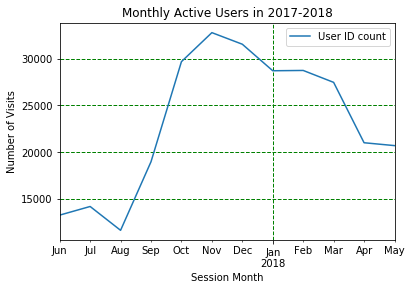

In [26]:
mau_visits.plot(x="session_month", y="uid", title='Monthly Active Users in 2017-2018', label='User ID count');
plt.xlabel('Session Month')
plt.ylabel('Number of Visits')
plt.grid(color='g', linestyle='--', linewidth=1)
plt.show()

**Промежуточные выводы:**
- уверенный рост пользовательской активности в период с августя 2017 года по ноябрь 2017 года;
- пик пользовательской активности в ноябре 2017 года;
- спад пользовательской активности начиная с ноября 2017 года;
- периоды плато в январе 2018 года и апреле 2018 года.

**График количества посещений по неделям:**

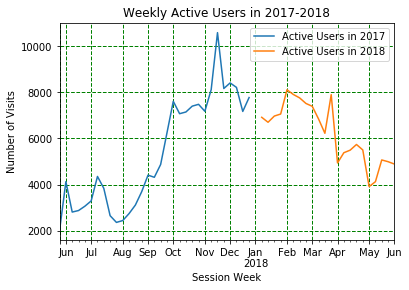

In [27]:
wau_visits_2017 = wau_visits.query('session_year == 2017')
wau_visits_2017['week_yr'] = pd.to_datetime(
    wau_visits_2017['session_year'].astype(str) + ' ' + wau_visits_2017['session_week'].astype(str) + ' 1',
                                format='%Y %U %w')
wau_visits_2018 = wau_visits.query('session_year == 2018')
wau_visits_2018['week_yr'] = pd.to_datetime(
    wau_visits_2018['session_year'].astype(str) + ' ' + wau_visits_2018['session_week'].astype(str) + ' 1',
                                format='%Y %U %w')

ax = wau_visits_2017.plot(x = 'week_yr',
                y = 'uid', 
                title='Weekly Active Users in 2017-2018', label='Active Users in 2017')
wau_visits_2018.plot(x = 'week_yr',
                y = 'uid',label='Active Users in 2018', ax=ax)
plt.xlabel('Session Week')
plt.ylabel('Number of Visits')
plt.grid(color='g', linestyle='--', linewidth=1)

plt.show()

**Промежуточные выводы:**
- данные разрываются в декабре 2017-2018 года;
- количества посещений изменяются не равномерно: наблюдаются частые пики прироста пользователей, так же, как и пики оттока;
- происходил набор количества активных пользователей с августа по конец ноября 2017 г., дальше все идет по наклонной.

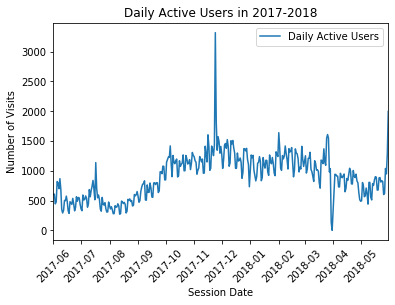

In [28]:
ax = dau_visits.plot(x = 'session_date',
                y = 'uid', 
                title='Daily Active Users in 2017-2018', label='Daily Active Users')

plt.xlabel('Session Date')
plt.xticks(rotation=45)
plt.ylabel('Number of Visits');

**Промежуточные выводы:**
- посчитанные метрики: `DAU: 907.99, WAU: 5716.25, MAU: 23228.42`;
- количества посещений изменяются не равномерно: наблюдаются частые пики прироста пользователей, так же, как и пики оттока;
- положительный пик по количеству для посещений в ноябре 2017 года и отрицательный пик в апреле 2018 года.

**Определим, сколько раз за день пользователи в среднем заходят на сайт:**

Выведем метрику средних посещений сайта в день одним пользователем daily_visits:

In [29]:
daily_visits = visits_log.groupby(['session_year', 'session_date']).agg({'uid': ['count','nunique']})
daily_visits.columns = ['total_visits', 'unique_users']
daily_visits['avg_daily_visits'] = daily_visits['total_visits'] / daily_visits['unique_users']
daily_visits = daily_visits.reset_index()
daily_visits.head()

,session_year,session_date,total_visits,unique_users,avg_daily_visits
0,2017,2017-06-01,664,605,1.097521
1,2017,2017-06-02,658,608,1.082237
2,2017,2017-06-03,477,445,1.071910
3,2017,2017-06-04,510,476,1.071429
4,2017,2017-06-05,893,820,1.089024


Построим график, отражающий изменения метрики во времени:

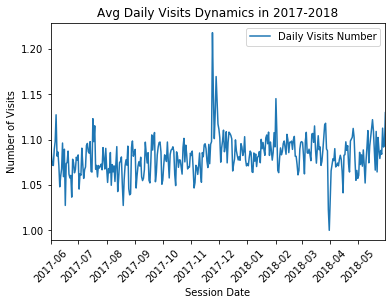

In [30]:
ax = daily_visits.plot(x = 'session_date',
                y = 'avg_daily_visits', 
                title='Avg Daily Visits Dynamics in 2017-2018', label='Daily Visits Number')

plt.xlabel('Session Date')
plt.xticks(rotation=45)
plt.ylabel('Number of Visits');

Как видим, в целом распределение `повторяет распределение среднего количества пользователей в день`, с учетом масштаба.

**Исследуем, сколько времени пользователи проводят на сайте.** 

Выведем продолжительность пользовательской сессии:

In [31]:
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds

Теперь построим график распределения:

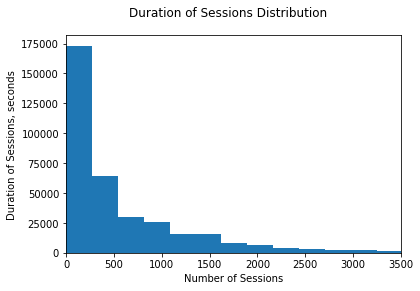

In [32]:
plt.hist(visits_log['session_duration_sec'], bins=len(visits_log['session_duration_sec'].unique()))
plt.xlabel('Number of Sessions')
plt.ylabel('Duration of Sessions, seconds')
plt.xlim(0, 3500)
plt.suptitle('Duration of Sessions Distribution')
plt.show()

При таком распределении среднюю продолжительность сессии определим через `mode`:

In [33]:
print('Средняя продолжительность сессии на сайте:',int(visits_log['session_duration_sec'].mode()))

Средняя продолжительность сессии на сайте: 60


**Промежуточные выводы:**
- В среднем, пользователи заходят на сайт около 1 раза в сутки;
- Как видим, `довольно короткая средняя сессия`.

**Выполним когортный анализ пользователей и рассчитаем Retention Rate**

Для расчетов создадим дубликат датафрейма visits_log под названием `user_activity`:

In [34]:
user_activity = visits_log
user_activity.head(1)

,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration_sec
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017,2017-12-01,51,2017-12-20,1080


Далее, для создания когорт создадим столбец `first_activity_date`:

In [35]:
user_activity['session_date'] = pd.to_datetime(user_activity['session_date'])
first_activity_date = user_activity.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
user_activity = user_activity.join(first_activity_date,on='uid')

In [36]:
user_activity.head(1)

,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017,2017-12-01,51,2017-12-20,1080,2017-12-20


Создадим когорты по месяцам (как следует из задания):

In [37]:
user_activity['session_month'] = user_activity['session_month'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')
user_activity['cohort_lifetime'] = (user_activity['session_month'] - user_activity['first_activity_month'])
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1, 'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')

cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg(
    {'uid':'nunique'}).reset_index()

cohorts.head()

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Определим `Retention Rate`. Для этого нужно найти количество пользователей, изначально бывших в когорте, и разделить на него  количество пользователей в каждую следующую неделю:

In [38]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
print(initial_users_count)

   first_activity_month  cohort_users
0            2017-06-01         13259
12           2017-07-01         13140
23           2017-08-01         10181
33           2017-09-01         16704
42           2017-10-01         25977
50           2017-11-01         27248
57           2017-12-01         25268
63           2018-01-01         22624
68           2018-02-01         22197
72           2018-03-01         20589
75           2018-04-01         15709
77           2018-05-01         15273


Объединим данные по когортам с исходным количеством пользователей в когорте:

In [39]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Рассчитаем Retention Rate:

In [40]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту:

In [41]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

In [42]:
retention_pivot.head()

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN


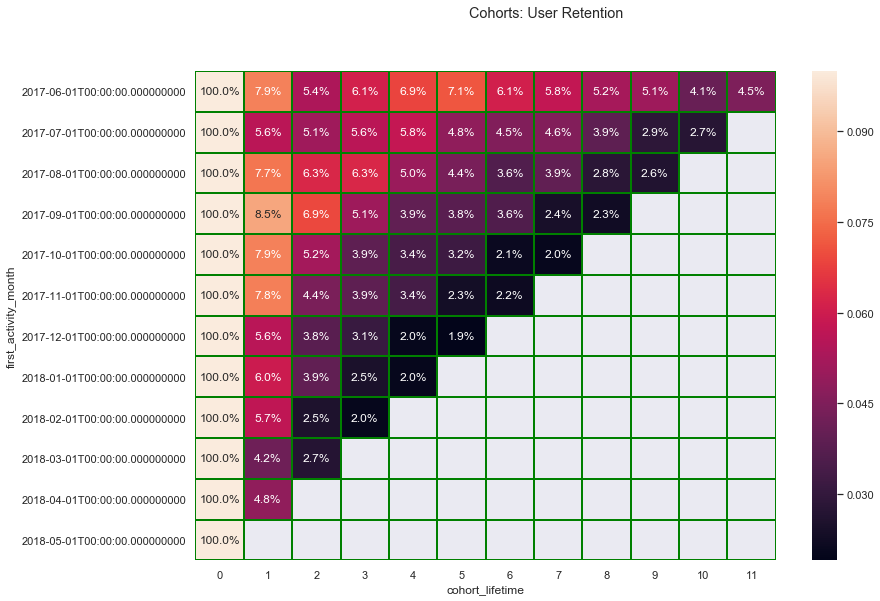

In [43]:
sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.suptitle('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='green', vmax=0.1);

**Промежуточные выводы:**
- Как мы видим, в целом очень невысокий Retention Rate;
- В целом заметно `убывание по месяцам`, но присутствует и `резкое увеличение` чуть позже середины жизненного цикла когорт. Возможно, в этот период посетители получают какое-то заманчивое предложение?
- Заметен равный срок существования последней и предпоследней когорты - это аномалия или особенность учета?

**Найдем средний Retention Rate на второй месяц «жизни» когорт:**

In [44]:
print(f'Retention Rate на второй месяц «жизни» когорт: {retention_pivot[2].mean():0.2%}')

Retention Rate на второй месяц «жизни» когорт: 4.63%


### 2.2. Метрики электронной коммерции <a class="anchor" id="second-two-bullet"></a>

**Проверим, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.** 

Для работы нам понадобится orders_log. Создадим его копию orders_CART, а также обратимся к ранее использованной таблице user_activity.

In [45]:
try:
    visits_log = pd.read_csv('visits_log.csv')
except:
    visits_log = pd.read_csv('/datasets/visits_log.csv')

visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits_log = visits_log[['uid','device', 'end_ts', 'source_id', 'start_ts']]

user_activity = visits_log.copy()
orders_CART = orders_log.copy()

visits_log.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


In [46]:
orders_CART.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [47]:
user_activity.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


Выведем таблицу с датой и временем первого посещения сайта:

In [48]:
user_activity['start_ts'] = pd.to_datetime(user_activity['start_ts'])
first_activity_date = user_activity.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
first_activity_date = first_activity_date.reset_index()
first_activity_date.head()

,uid,first_activity_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Проведем такую же манипуляцию с таблицей заказов:

In [49]:
orders_CART['buy_ts'] = pd.to_datetime(orders_CART['buy_ts'])
first_order_date = orders_CART.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_date'
first_order_date = first_order_date.reset_index()
first_order_date.head()

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Срастим таблицу размещенных заказов с данными о первом посещении:

In [50]:
orders_table = pd.merge(first_activity_date, first_order_date, how='left', on='uid')
orders_table.head()

,uid,first_activity_date,first_order_date
0,11863502262781,2018-03-01 17:27:00,NaT
1,49537067089222,2018-02-06 15:55:00,NaT
2,297729379853735,2017-06-07 18:47:00,NaT
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
4,325320750514679,2017-09-30 14:29:00,NaT


Проверим долю заказчиков от числа общих посетителей:

In [51]:
orders_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228169 entries, 0 to 228168
Data columns (total 3 columns):
uid                    228169 non-null uint64
first_activity_date    228169 non-null datetime64[ns]
first_order_date       36523 non-null datetime64[ns]
dtypes: datetime64[ns](2), uint64(1)
memory usage: 7.0 MB


Как видим, если считать по первому посещение и первому заказу, получаем, что только 16% пользователей разместили заказ. Оставим только этих пользователей и добавим в таблице разнице во времени между заказом и посещением в минутах:

In [52]:
orders_table = orders_table.dropna()
orders_table['cart_time'] = orders_table['first_order_date'] - orders_table['first_activity_date']
orders_table['cart_time'] = orders_table['cart_time'].astype('timedelta64[m]')
orders_table.head()

,uid,first_activity_date,first_order_date,cart_time
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
22,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
35,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
36,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
38,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


Проверим диапазон значений:

In [53]:
orders_table.describe()

,uid,cart_time
count,3.652300e+04,36523.000000
mean,9.213152e+18,24340.175834
std,5.324792e+18,67784.774690
min,3.135781e+14,0.000000
25%,4.615081e+18,4.000000
50%,9.245161e+18,16.000000
75%,1.383709e+19,2897.000000
max,1.844617e+19,523144.000000


Как видим, присутствуют экстремальные значения - допустим, максимальное значение составляет год. Такие значения неинтересны для расчета среднего времени. Проверим распределение:

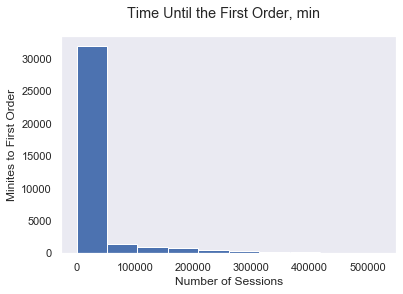

In [54]:
plt.hist(orders_table['cart_time'], bins=10)
plt.xlabel('Number of Sessions')
plt.ylabel('Minites to First Order')
plt.suptitle('Time Until the First Order, min')
plt.show()

Т.к. распределение не нормальное, получим среднее значение по моде:

In [55]:
print('Среднее время до размещения заказа:',int(orders_table['cart_time'].mode()),"минут")

Среднее время до размещения заказа: 1 минут


Посмотрим также распределение на диаграмме размаха:

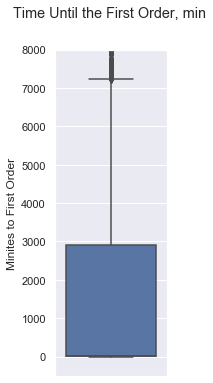

In [56]:
fig = plt.figure(figsize=(2, 6))
sns.set()
sns.boxplot(y='cart_time', data=orders_table)
plt.ylim(-500, 8000)
plt.xlabel('')
plt.ylabel('Minites to First Order')
plt.suptitle('Time Until the First Order, min')
plt.show()

Как видим, диапазон времени на заказ варьируется до 3000 минут, все, что выше 7000 минут - выбросы. Но заказчикам вряд ли будут интересны цифры за пределами одного дня. Поэтому оставим значение по моде.

**Промежуточные выводы**:
- к заказу приходит лишь 16% посетителей сайта;
- среднее время, за которое пользователь осуществляет заказ, составляет 1 минуту.

**Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев**

Создадим рабочий датафрейм orders_6MON, добавим в него дату первой покупки и последней покупки, прибавив timedelta 6 месяцев:

In [57]:
orders_6MON = orders_log.copy()

orders_6MON['buy_ts'] = pd.to_datetime(orders_6MON['buy_ts'])
first_order_date = orders_6MON.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders_6MON = orders_6MON.join(first_order_date, on='uid')
orders_6MON['last_order_date'] = orders_6MON['first_order_date'] +  np.timedelta64(6, 'M')
orders_6MON.head()

,buy_ts,revenue,uid,first_order_date,last_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-11-30 15:04:36
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-11-30 15:19:36
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-11-30 15:21:36
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-11-30 15:23:36
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-11-30 22:52:36


Выделим значения первого и последнего месяцев покупки:

In [58]:
orders_6MON = orders_6MON.query('buy_ts <= last_order_date')
orders_6MON['first_month'] = orders_6MON['first_order_date'].astype('datetime64[M]')
orders_6MON['last_month'] = orders_6MON['last_order_date'].astype('datetime64[M]')
orders_6MON = orders_6MON.query('revenue > 0')
orders_6MON.tail()

,buy_ts,revenue,uid,first_order_date,last_order_date,first_month,last_month
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-11-30 14:44:36,2018-05-01,2018-11-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-11-30 14:44:36,2018-05-01,2018-11-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-11-30 14:48:36,2018-05-01,2018-11-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-11-30 14:50:36,2018-05-01,2018-11-01
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01 00:02:00,2018-11-30 14:56:36,2018-06-01,2018-11-01


Сгруппируем наши заказы по когортам, выведем количество заказов и общую выручку:

In [59]:
cohort_6_month_orders = orders_6MON.groupby('last_month').agg({'uid':'nunique','revenue': 'count'})
cohort_6_month_orders.columns = ['unique_ids', 'total_orders_qty']
cohort_6_month_orders['avg_orders_per_user'] = cohort_6_month_orders['total_orders_qty']/cohort_6_month_orders['unique_ids']
cohort_6_month_orders = cohort_6_month_orders.reset_index()
cohort_6_month_orders['last_month'] = cohort_6_month_orders['last_month'].dt.date
cohort_6_month_orders.head(20)

,last_month,unique_ids,total_orders_qty,avg_orders_per_user
0,2017-11-01,7,8,1.142857
1,2017-12-01,2067,3561,1.722787
2,2018-01-01,1908,2660,1.394130
3,2018-02-01,1193,1625,1.362112
4,2018-03-01,2636,3933,1.492033
5,2018-04-01,4178,5615,1.343944
6,2018-05-01,4199,5884,1.401286
7,2018-06-01,4222,5810,1.376125
8,2018-07-01,3351,4292,1.280812
9,2018-08-01,4098,5003,1.220839


Покажем данную динамику на столбчатой диаграмме:

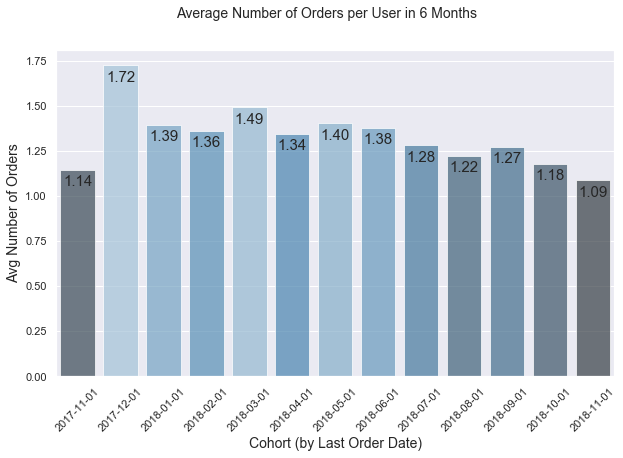

In [60]:
plt.figure(figsize=(10, 6))

x=cohort_6_month_orders['last_month']
y=cohort_6_month_orders['avg_orders_per_user']

splot=sns.barplot(x,y, data=cohort_6_month_orders, hue=y, palette="Blues_d", dodge=False, alpha=0.7)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.xlabel("Cohort (by Last Order Date)", size=14)
plt.xticks(rotation=45)
plt.ylabel("Avg Number of Orders", size=14)
plt.suptitle('Average Number of Orders per User in 6 Months', size=14)
plt.legend([],[], frameon=False)
plt.show()

**Посчитаем среднее количество покупок по всем когортам:** 

In [61]:
mean_purch_one_user = round(cohort_6_month_orders['avg_orders_per_user'].mean(),2)

print("Среднее количество покупок на пользователя по всем когортам:",mean_purch_one_user)

Среднее количество покупок на пользователя по всем когортам: 1.33


**Промежуточные выводы:**

- как видим, за исключением самой первой когорты, в более ранних когортах покупок на пользователя совершали больше;
- количество покупок за полгода в каждой последующей когорте постепенно уменьшается;
- среднее количество заказов на пользователя по всем когортам: 1.33.

**Рассчитаем средний чек, применив группировку по времени совершения покупки**

Для этого выделим месяц при помощи функции datetime на столбце buy_ts и сгруппируем по месяцам с усреднением по выручке.

In [62]:
orders_CHECK = orders_log.copy()
orders_CHECK['buy_ts'] = pd.to_datetime(orders_CHECK['buy_ts'])
orders_CHECK['order_month'] = orders_CHECK['buy_ts'].astype('datetime64[M]')
orders_CHECK = orders_CHECK.groupby('order_month')['revenue'].mean()
orders_CHECK = orders_CHECK.reset_index()
orders_CHECK.head()

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280


Отразим динамику изменения среднего чека на графике:

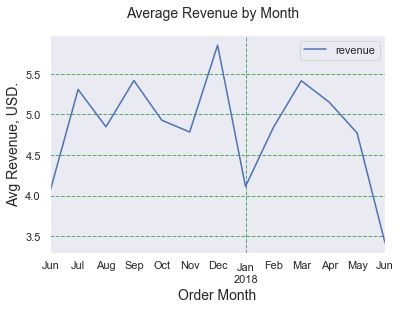

In [63]:
orders_CHECK.plot(x="order_month", y="revenue")
plt.xlabel('Order Month', size=14)
plt.ylabel('Avg Revenue, USD.', size=14)
plt.grid(color='g', linestyle='--', linewidth=1)
plt.suptitle('Average Revenue by Month', size=14)
plt.show()

**Рассчитаем среднюю сумму чека за весь период:**

In [64]:
mean_value_all_time = round(orders_CHECK['revenue'].mean(),2)

print("Средняя сумма чека за все время:",mean_value_all_time)

Средняя сумма чека за все время: 4.84


**Промежуточные выводы:**
- отметим грубые ежемесячные циклы в суммах заказа до 2017 года (т.е. в один месяц увеличение суммы. в другой - уменьшение);
- пик по чеку заказа пришелся на декабрь 2017 года, затем идет резкое падение сумм по чеку;
- с марта 2018 года идет постоянное падение средней суммы чека;
- сумма среднего чека за весь срок проекта - 4.84 у.е.

**Выясним, как меняется LTV на покупателя по когортам**

Для создания месячных когорт  выделим месяцы из дат в таблице с заказами:

In [65]:
orders_LTV = orders_log.copy()
orders_LTV['buy_ts'] = pd.to_datetime(orders_LTV['buy_ts'])
orders_LTV['order_month'] = orders_LTV['buy_ts'].astype('datetime64[M]')
orders_LTV.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


Добавим данные по первой покупке:

In [66]:
first_orders = orders_LTV.groupby('uid')['order_month'].min().reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [67]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [68]:
orders_new = pd.merge(orders_LTV,first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [69]:
cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [70]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Добавим в таблицу возраст когорт:

In [71]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [72]:
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)

output = output.cumsum(axis=1).round(2)

In [73]:
output.head(20)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отобразим значения на тепловой карте:

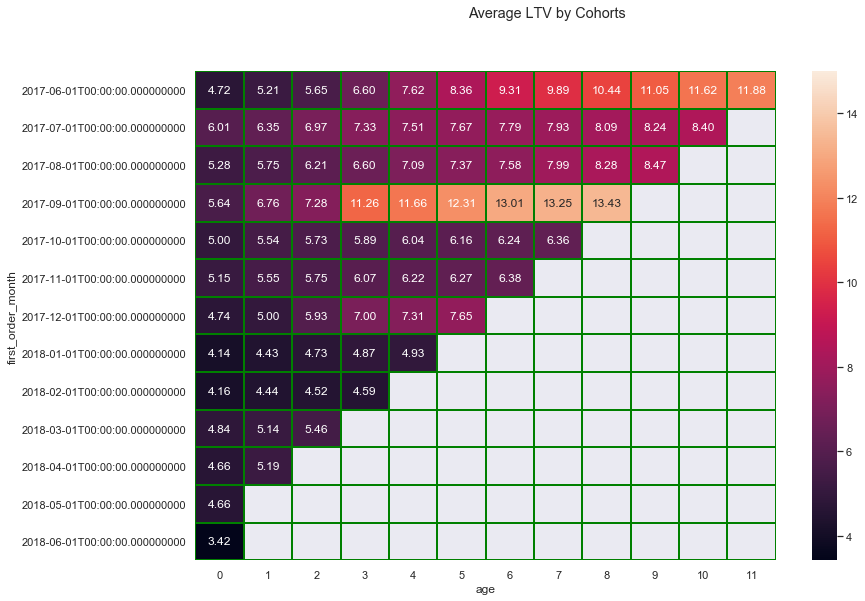

In [74]:
sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.suptitle('Average LTV by Cohorts')
sns.heatmap(output, annot=True, linewidths=1, fmt='.2f',linecolor='green',vmax=15);

**Рассчитаем среднее LTV по когортам возрастом 6 месяцев:**

In [75]:
six_mon_ltv_mean = round(output[5].mean(),2)
print("Среднее LTV за 6-ой месяц когорт:",six_mon_ltv_mean)

Среднее LTV за 6-ой месяц когорт: 7.97


### 2.3. Маркетинговые метрики<a class="anchor" id="second-three-bullet"></a>

Посчитаем и отобразим на графиках, как маркетинговые метрики различаются по рекламным источникам.

- Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам;
- Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика;
- Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт;
- Построим графики, отражающие изменения метрик во времени.

In [76]:
m_visits = visits_log.copy()
m_orders = orders_log.copy()
m_costs = costs.copy()

In [77]:
m_costs.tail(1)

,source_id,dt,costs
2541,10,2018-05-31,17.6


In [78]:
m_visits.head(1)

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00


In [79]:
m_orders.head(1)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.0,10329302124590727494


**Посчитаем общую сумму расходов на маркетинг:**

In [80]:
marketing_total = round(sum(m_costs['costs']),2)
print("Общая сумма расходов на маркетинг:",marketing_total, 'у.е.')

Общая сумма расходов на маркетинг: 329131.62 у.е.


Отразим разбивку расходов по источникам:

In [81]:
marketing_total_gb = m_costs.groupby('source_id')['costs'].sum().reset_index()
marketing_total_gb.head(10)

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Покажем распределение по источникам на круговой диаграмме:

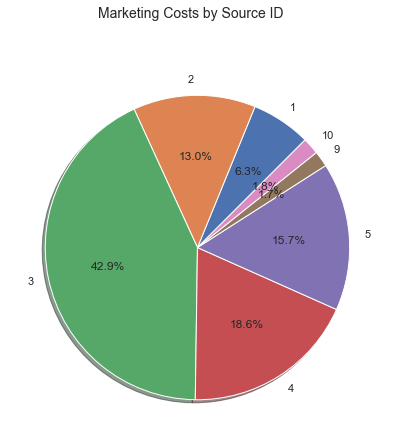

In [82]:
plt.figure(figsize=(7, 7))

labels = marketing_total_gb['source_id']
sizes = marketing_total_gb['costs']

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45);

plt.suptitle('Marketing Costs by Source ID', size=14)
plt.show()

Для построения графика изменения значений по времени создадим сводную таблицу:

In [83]:
marketing_pivot = (
    m_costs.groupby(['source_id', 'dt'])
    .agg({'costs': 'mean'})
    .reset_index())

marketing_pivot.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Строим график:

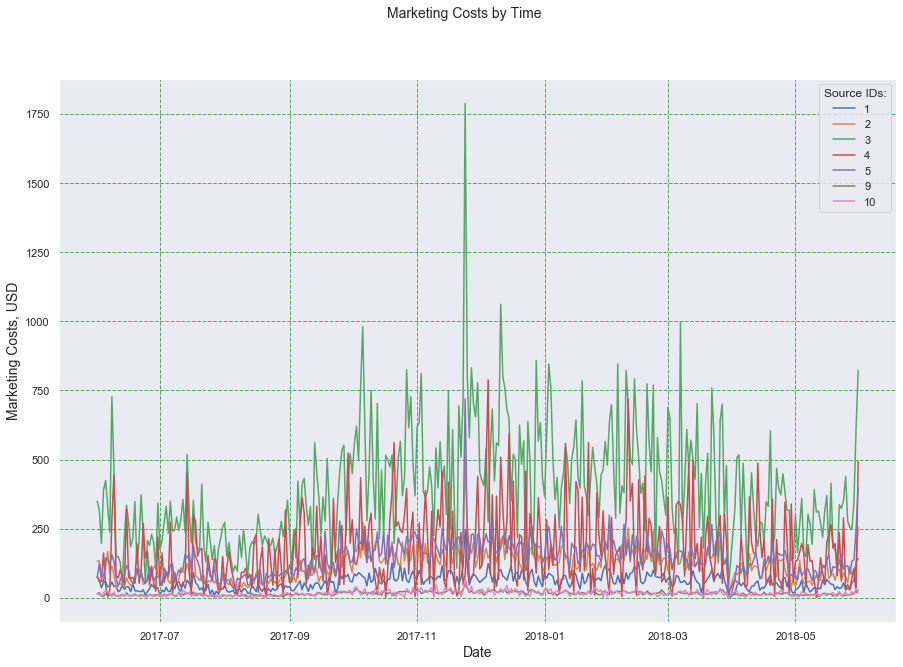

In [84]:
plt.figure(figsize=(15, 10))
for idx in marketing_pivot['source_id'].unique():
    x = marketing_pivot[marketing_pivot['source_id']==idx]['dt']
    y = marketing_pivot[marketing_pivot['source_id']==idx]['costs']
    plt.plot(x, y)

labels = [idx for idx in marketing_pivot['source_id'].unique()]
plt.xlabel('Date', size=14)
plt.ylabel('Marketing Costs, USD', size=14)
plt.grid(color='g', linestyle='--', linewidth=1)
plt.suptitle('Marketing Costs by Time', size=14)
plt.legend(labels, title="Source IDs:")
plt.show()

График по сырым данным получается не сильно репрезентативный: слишком много распределений по датам и слишком мелкий масштаб. Имеет смысл укрупнить данные и построить график по среднемесячным значениям. Подготовим данные:

In [85]:
marketing_pivot['month'] = marketing_pivot['dt'].astype('datetime64[M]')

In [86]:
mean_pivot = (
    marketing_pivot.groupby(['source_id', 'month'])
    .agg({'costs': 'mean'})
    .reset_index())

mean_pivot.head()

,source_id,month,costs
0,1,2017-06-01,37.520333
1,1,2017-07-01,34.609032
2,1,2017-08-01,30.703548
3,1,2017-09-01,50.067000
4,1,2017-10-01,74.701613


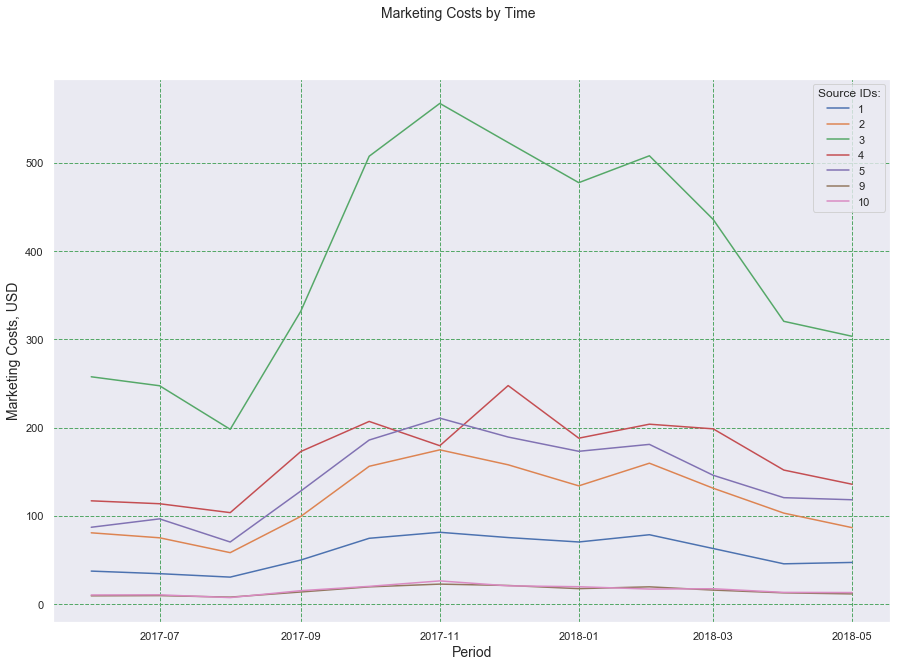

In [87]:
plt.figure(figsize=(15, 10))
for idx in mean_pivot['source_id'].unique():
    x = mean_pivot[mean_pivot['source_id']==idx]['month']
    y = mean_pivot[mean_pivot['source_id']==idx]['costs']
    plt.plot(x, y)

labels = [idx for idx in mean_pivot['source_id'].unique()]

plt.xlabel('Period', size=14)
plt.ylabel('Marketing Costs, USD', size=14)
plt.grid(color='g', linestyle='--', linewidth=1)
plt.suptitle('Marketing Costs by Time', size=14)
plt.legend(labels, title="Source IDs:")
plt.show()

**Промежуточные выводы:**

- очень жаль, что мы не видим названий категорий источников расходов;
- довольно заметна значительная доля расходов по источнику №3;
- общая доля расходов по остальным источникам более-менее постоянна, даже увеличение-уменьшение бюджета по разным категориям происходило синхронно (за исключением категории №3!). Такое ощущение, что дают общий бюджет и независимо от размера каждому распределяют определенный процент;
- а вот категория №3 имела экстремальное значение в 1750 у.е. в новогодний период 2017-2018 года;
- наблюдаются пики по определенным источникам, если бы мы знали больше об этих источниках, можно было бы судить о том, какие вложения были логичны (допустим, газет сегодня читают мало, и даже на Новый год выхлопа от рекламы будет немного, но в случае вещательных медиа понятие prime time довольно актуально)

**Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика.**

Посчитаем CAC для каждого источника трафика:

К файлу orders подтянем данные из файла visits, где выберем первый источник перехода:

In [88]:
# загружаю visits_log заново, т.к. прошлый файл был изменен - добавлены столбцы, 
# хотя можно было бы и с уже открытым файлом работать.
try:
    visits_log = pd.read_csv('visits_log.csv')
except:
    visits_log = pd.read_csv('/datasets/visits_log.csv')

m_orders = orders_log.copy()

visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits_log = visits_log[['uid','device', 'end_ts', 'source_id', 'start_ts']]
m_visits = visits_log.copy()
m_visits.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


Оставим только первое упоминание источника:

In [89]:
m_visits = m_visits.groupby('uid').first().reset_index()
m_visits.head()

,uid,device,end_ts,source_id,start_ts
0,11863502262781,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00
1,49537067089222,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00
2,297729379853735,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00
3,313578113262317,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00
4,325320750514679,desktop,2017-09-30 14:38:00,5,2017-09-30 14:29:00


Теперь делаем сращение:

In [90]:
orders_with_id = pd.merge(m_orders, m_visits, on='uid', how='left')
orders_with_id.head()

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00


Проверим, есть ли пропущенные source id:

In [91]:
orders_with_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 7 columns):
buy_ts       50415 non-null datetime64[ns]
revenue      50415 non-null float64
uid          50415 non-null uint64
device       50415 non-null object
end_ts       50415 non-null object
source_id    50415 non-null int64
start_ts     50415 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(3), uint64(1)
memory usage: 3.1+ MB


Теперь подтянем информацию из файла costs, чтобы подсчитать затраты по каждому источнику, сгруппируем таблицу по источнику и месяцам:

In [92]:
id_costs = costs.copy()
id_costs['month'] = id_costs['dt'].astype('datetime64[M]')
id_costs_gb = (id_costs.groupby(['source_id', 'month'])
    .agg({'costs': 'sum'})
    .reset_index())
id_costs_gb.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Аналогично подготовим и сгруппируем таблицу orders_with_id:

In [93]:
orders_with_id['buy_month'] = orders_with_id['buy_ts'].astype('datetime64[M]')
orders_with_id_gb = (orders_with_id.groupby(['source_id', 'buy_month'])
    .agg({'uid': 'nunique'})
    .reset_index())

orders_with_id_gb.head()

,source_id,buy_month,uid
0,1,2017-06-01,203
1,1,2017-07-01,222
2,1,2017-08-01,163
3,1,2017-09-01,316
4,1,2017-10-01,454


Объединим две таблицы:

In [94]:
orders_with_id_and_cost = pd.merge(
    orders_with_id_gb, id_costs_gb, 
    how='left', left_on=['source_id','buy_month'], right_on = ['source_id','month'])

orders_with_id_and_cost.head()

,source_id,buy_month,uid,month,costs
0,1,2017-06-01,203,2017-06-01,1125.61
1,1,2017-07-01,222,2017-07-01,1072.88
2,1,2017-08-01,163,2017-08-01,951.81
3,1,2017-09-01,316,2017-09-01,1502.01
4,1,2017-10-01,454,2017-10-01,2315.75


Все отлично, теперь можно работать дальше над определением `CAC для каждого источника трафика`.

In [95]:
orders_with_id_and_cost['cac'] = (orders_with_id_and_cost['costs']/orders_with_id_and_cost['uid']).round(2)
orders_with_id_and_cost.head()

,source_id,buy_month,uid,month,costs,cac
0,1,2017-06-01,203,2017-06-01,1125.61,5.54
1,1,2017-07-01,222,2017-07-01,1072.88,4.83
2,1,2017-08-01,163,2017-08-01,951.81,5.84
3,1,2017-09-01,316,2017-09-01,1502.01,4.75
4,1,2017-10-01,454,2017-10-01,2315.75,5.10


In [96]:
cac_by_source = orders_with_id_and_cost.groupby(['source_id']).agg({'cac': 'mean'}).reset_index()
cac_by_source.head()

,source_id,cac
0,1,4.840833
1,2,8.270000
2,3,14.739167
3,4,6.154167
4,5,6.948333


**Найдем значение CAC для всего проекта:**

In [97]:
cac_total = round(cac_by_source['cac'].mean(),2)

print("Средняя сумма привлечения клиента для всего проекта:",cac_total, "у.е.")

Средняя сумма привлечения клиента для всего проекта: 7.04 у.е.


Отразим данные метрики на графике:

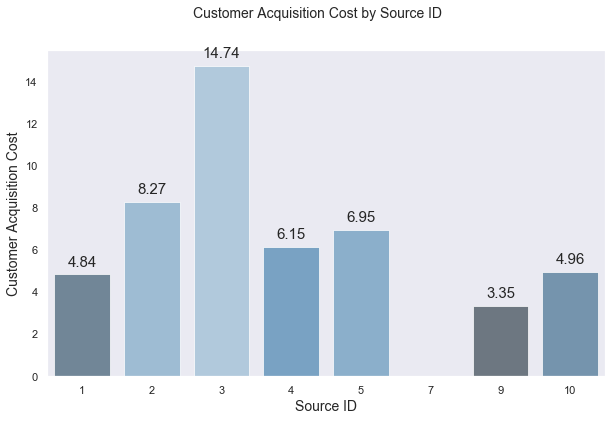

In [98]:
plt.figure(figsize=(10, 6))

x=cac_by_source['source_id']
y=cac_by_source['cac']

splot=sns.barplot(x,y, data=cac_by_source, hue=y, palette="Blues_d", dodge=False, alpha=0.7)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 12), 
                   textcoords = 'offset points')

plt.xlabel("Source ID", size=14)
plt.ylabel("Customer Acquisition Cost", size=14)
plt.suptitle('Customer Acquisition Cost by Source ID', size=14)
plt.legend([],[], frameon=False)
plt.show()

**Промежуточные выводы:**
- как видим, самая низкая стоимость привлечения клиентов - по источникам №9 и №10;
- самая высокая стоимость привлечения - по источнику №3;
- если вспомним прошлый раздел, в источник №3 вкладывается огромное количество средств;
- по источнику 7 либо нет данных либо не вкладывали ничего.

**Рассчитаем ROMI по когортам в разрезе источников.**

In [99]:
orders_with_id.head()

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017-06-01


In [100]:
try:
    costs = pd.read_csv('costs.csv')
except:
    costs = pd.read_csv('/datasets/costs.csv')

costs_ROMI = costs.copy()
costs_ROMI.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Получим столбцы с указаниями первого и фактического месяцев покупок:

In [101]:
orders_with_id['order_month'] = orders_with_id['buy_ts'].astype('datetime64[M]')
costs_ROMI['month'] = costs_ROMI['dt'].astype('datetime64[M]')

first_orders = orders_with_id.groupby(['uid']).agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [102]:
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Получим таблицу с указанием месяцев, сгруппируем ее по количеству заказов и сумме выручки за месяц:

In [103]:
orders_first_month = pd.merge(orders_with_id, first_orders, on='uid')
report = (orders_first_month.groupby(['first_order_month', 'source_id', 'order_month'])
    .agg({'uid': 'nunique', 'revenue': 'sum'})
    .reset_index())

Создадим таблицу в которой отображается общее количество пользователей в когорте:

In [104]:
report_uid = (report.groupby(['first_order_month', 'source_id'])
    .agg({'uid': 'max'})
    .reset_index())

report_uid.head()

,first_order_month,source_id,uid
0,2017-06-01,1,203
1,2017-06-01,2,271
2,2017-06-01,3,574
3,2017-06-01,4,417
4,2017-06-01,5,368


Теперь добавим эти данные в нашу помесячную таблицу и переименуем столбцы для лучшей читаемости:

In [105]:
report = pd.merge(report, report_uid, on = ['first_order_month', 'source_id'], how = 'left')
report.columns =  [ 'first_order_month','source_id', 'order_month', 'new_buyers', 'revenue', 'n_buyers']
report.head()

,first_order_month,source_id,order_month,new_buyers,revenue,n_buyers
0,2017-06-01,1,2017-06-01,203,1168.45,203
1,2017-06-01,1,2017-07-01,11,362.94,203
2,2017-06-01,1,2017-08-01,10,153.72,203
3,2017-06-01,1,2017-09-01,13,695.88,203
4,2017-06-01,1,2017-10-01,14,760.74,203


Маржинальность сервиса составляет 100%, так что можно считать по чистой выручке, но для отработки навыков введем переменную margin_rate. Добавим в таблицу значения gross profit и lifetime value.

In [106]:
margin_rate = 1 
report['gp'] = report['revenue'] * margin_rate
report['ltv'] = report['gp'] / report['n_buyers']
report.head()

,first_order_month,source_id,order_month,new_buyers,revenue,n_buyers,gp,ltv
0,2017-06-01,1,2017-06-01,203,1168.45,203,1168.45,5.755911
1,2017-06-01,1,2017-07-01,11,362.94,203,362.94,1.787882
2,2017-06-01,1,2017-08-01,10,153.72,203,153.72,0.757241
3,2017-06-01,1,2017-09-01,13,695.88,203,695.88,3.427980
4,2017-06-01,1,2017-10-01,14,760.74,203,760.74,3.747488


Получим таблицу, в которой ежемесячная сумма расходов сгруппирована по источнику перехода:

In [107]:
monthly_costs = costs_ROMI.groupby(['month','source_id']).agg({'costs': 'sum'}).reset_index()
monthly_costs.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Срастим наши таблицы, получив данные и о выручке и о затратах. Сращение производим по двум столбцам: `по месяцу и источнику перехода`.

In [108]:
report_new = pd.merge(
    report, monthly_costs, left_on=['first_order_month','source_id'], right_on=['month','source_id'])

report_new.head()

,first_order_month,source_id,order_month,new_buyers,revenue,n_buyers,gp,ltv,month,costs
0,2017-06-01,1,2017-06-01,203,1168.45,203,1168.45,5.755911,2017-06-01,1125.61
1,2017-06-01,1,2017-07-01,11,362.94,203,362.94,1.787882,2017-06-01,1125.61
2,2017-06-01,1,2017-08-01,10,153.72,203,153.72,0.757241,2017-06-01,1125.61
3,2017-06-01,1,2017-09-01,13,695.88,203,695.88,3.427980,2017-06-01,1125.61
4,2017-06-01,1,2017-10-01,14,760.74,203,760.74,3.747488,2017-06-01,1125.61


Подсчитаем значения CAC и ROMI, подготовим сводную таблицу по среднему ROMI:

In [109]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']

output = report_new.pivot_table(
    index='first_order_month', columns='source_id', values='romi', aggfunc='mean')

print(output.cumsum(axis=0).round(2).fillna(''))

source_id            1     2     3     4     5     9     10
first_order_month                                          
2017-06-01         0.52  0.22  0.03  0.07  0.13  0.15  0.13
2017-07-01         0.83  0.32  0.06  0.17  0.21  0.35  0.29
2017-08-01         0.96  0.39  0.09  0.24  0.37  0.77  0.46
2017-09-01         1.30  1.10  0.13  0.32  0.46  0.95  0.51
2017-10-01         1.49  1.25  0.17  0.44  0.59  1.13  0.65
2017-11-01         1.69  1.37  0.23  0.63  0.66  1.32  0.75
2017-12-01         1.87  1.87  0.28  0.76  0.78  1.52  0.90
2018-01-01         2.13  1.97  0.33  0.89  0.91  1.67  1.12
2018-02-01         2.40  2.07  0.40  1.09  1.06  1.88  1.36
2018-03-01         3.06  2.29  0.50  1.37  1.28  2.25  1.73
2018-04-01         3.79  2.55  0.61  1.77  1.58  2.58  2.11
2018-05-01         4.93  3.62  0.93  2.63  2.15  3.14  3.28


Как видно, у разных источников трафика по разным когортам окупаемость может быть разной: какой-то источник сразу окупается, какой-то нет. Покажем эти данные на диаграмме heatmap.

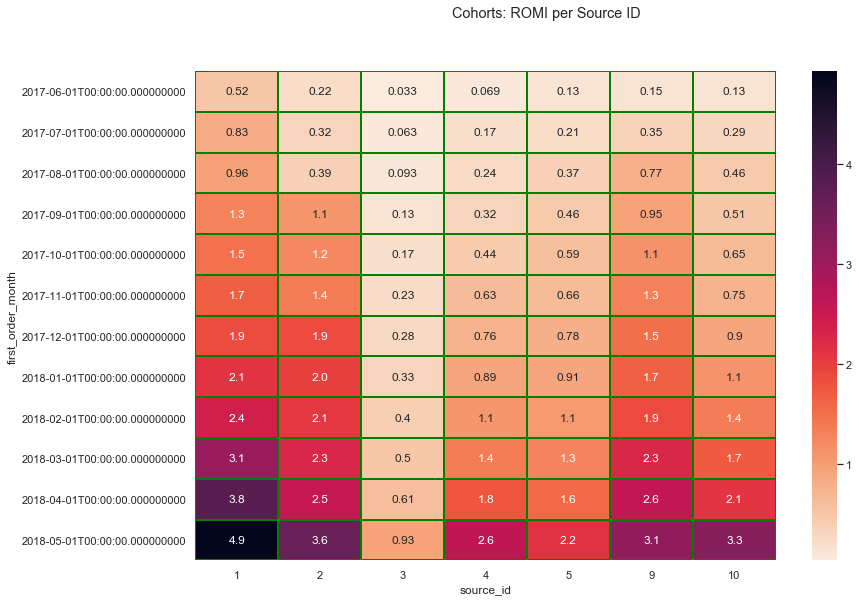

In [110]:
sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.suptitle('Cohorts: ROMI per Source ID')
sns.heatmap(output.cumsum(axis=0), annot=True, fmt='.2', linewidths=1, linecolor='green', cmap = sns.cm.rocket_r);

**Промежуточные выводы:**
- окупаемость у разных источников разная: видно, что источник 3 не окупается за весь срок существования;
- источники 1 и 2 окупились на четвертый месяц сущестования, за ними следует источник 9 и затем 10, 5 и 4;
- источник 1 приносит больше всего прибыли с вложений.

**2.4. Общие выводы по разделу:** <a class="anchor" id="second-four-bullet"></a>
    
- Изучение метрик завершено, промежуточные выводы размещены в соответствующих разделах;
- Общие выводы и рекомендации будут представлены в следующем разделе. 

[К НАЧАЛУ РАЗДЕЛА...](#second-bullet)

[К СОДЕРЖАНИЮ...](#zero-bullet)

# 3. Выводы и рекомендации <a class="anchor" id="third-bullet"></a>

Нами было проведено исследование источников трафика для сервис "Яндекс.Афиша" на основании данных с июня 2017 по конец мая 2018 года. По результатам исследования считаем необходимы обратить внимание на следующие наблюдения.

### Выводы и рекомендации по пользовательской базе

**Пользовательская сессия:**
- Посчитанные метрики: `DAU: 907.99 человек, WAU: 5716.25 человек, MAU: 23228.42 человек`.
- Довольно короткая средняя пользовательская сессия - около 60 секунд.
- Пользователи заходят на сайт в среднем лишь 1 раз в сутки.
- Был пик посещений в конце ноября 2017 года - сказалась особая рекламная кампания? Нужно проверить архивы рекламных событий / тарифных планов.

**Retention Rate:**
- Индекс удержания пользователей довольно низкий. Если это не является нормой в индустрии,  группе маркетинга следует увеличить вложения в пользовательскую базу.

**Средний чеку по времени:**
- Отметим ежемесячные циклы в суммах заказа до 2017 года (т.е. в один месяц увеличение суммы. в другой - уменьшение);
- Пик по чеку заказа пришелся на декабрь 2017 года, затем идет резкое падение сумм по чеку. Что происходило в декабре 2017 года - предпраздничный сезон или хорошая маркетинговая кампания? Или комбинация этих факторов?
- С марта 2018 года идет постоянное падение средней суммы чека.

**Скорость оформления первого заказа:**
- У более ранних когорт покупки совершались гораздо быстрее, и со временем время размещения первого заказа агрессивно растет;
- Что-то случилось в июне 2018 года, заказы размещались быстро, но дальнейшая статистика отсутствует, и мы не можем сделать вывод, связано ли это с гениальным маркетинговым ходом или же это случайная величина.

**Согласно метрике LTV + среднему кол-ву заказов на пользователя:**
- Первые когорты в целом приносили больше прибыли, пользователи совершали больше покупок. Необходимо дальнейшее изучение пользовательских условий, возможно со временем они стали людям менее интересны.
- Неожиданное падение LTV у третьей когорты. Хотя это может быть связано с учетной аномалией предыдущей когорты, из-за чего часть пользователей перешла в нее.


### Выводы и рекомендации по источникам трафика и вложениям в маркетинг 

**Согласно метрике ROMI:**
- Источники 1 и 2 окупились на четвертый месяц сущестования, за ними следует источник 9 и затем 10, 5 и 4. Особо приоритетными из них следует признать источники 1 и 2.
- Видно, что источник 3 не окупается за весь срок существования.

**Согласно метрике Marketing Cost by Time:**
- В источник 3 происходило крупное вливание средств, однако, заметного эффекта это не произвело, как следует из метрики ROMI. Следует уменьшить вложения в него в пользу остальных либо вовсе отказаться. Также непонятны такие значительные вливания средств в этот источник с учетом того, что стоимость привлечения клиентов в нем относительно ниже, чем в остальных (метрика CAC).

**Согласно метрике CAC:**
- Источники 1 и 2 пришли к окупаемости очень быстро согласно графику ROMI (при этом источник 1 требовали вложений  меньше, чем остальные, стоимость привлечения через источник 2 все же выше). Необходимо рассмотреть приоритетность сохранения этих источников.

**Согласно метрике Marketing Cost by Source ID:**
- Источники 3, 4, 5 и 2 занимают самые крупные доли по маркетинговым расходам, однако, согласно метрике ROMI лишь источники 2, 4 и 5 относительно быстро окупаемы. Доля источников 1, 10 и 9 мала, притом, что их окупаемость заметно выше. Нужно увеличить доли вложений в эти источники, приоритетно источники 1 и 2.

**Особые замечания**
- Имеются недостатки в данных, так, `отсутствуют данные по расходам на источники 6 и 7`, поэтому они не вошли в некоторые исследования. Причина отсутствия нам неизвестна.

[К НАЧАЛУ РАЗДЕЛА...](#third-bullet)

[К СОДЕРЖАНИЮ...](#zero-bullet)